The data contains eight attributes.

TYPE - This is an information column. The value is 'Electric usage' for all the observations.

DATE - Date of electric consumption. There is no timestamp in this field.


START TIME - Start time of the consumption.

END TIME - End time of the consumption

USAGE - Consumption in kWh

UNITS - This column denotes measurement unit. It is kWh for all the observations.

COST - Cost of consumption in $.

NOTES - Mostly an empty column

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080019 sha256=cb3e4ed528d51a7b2586727cf6905d0deeb26fe6b4088c425dd5b9820e47b8c9
  Stored in directory: /root/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.3
    Uninstalling bokeh-2.4.3:
      Successfully uninstalled bokeh-2.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("/content/sample_data/D202.csv")

#Dataset
 #https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data

In [ ]:
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [ ]:
#Since the whole column NOTES is empty we can simply drop it
df.drop(columns=['NOTES'], inplace=True)

In [ ]:
#Checking for null values
df.isna().sum()

TYPE          0
DATE          0
START TIME    0
END TIME      0
USAGE         0
UNITS         0
COST          0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.8+ MB


In [ ]:
#Extracting
df['year'] = pd.DatetimeIndex(df['DATE']).year
df['month'] = pd.DatetimeIndex(df['DATE']).month
df['day'] = pd.DatetimeIndex(df['DATE']).day

df['hour'] = pd.DatetimeIndex(df['START TIME']).hour
df['minute'] = pd.DatetimeIndex(df['START TIME']).minute

In [ ]:
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,year,month,day,hour,minute
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,2016,10,22,0,0
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,2016,10,22,0,15
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,2016,10,22,0,30
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,2016,10,22,0,45
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,2016,10,22,1,0


In [ ]:
df['DATETIME'] = df['DATE'] + df['START TIME']
for index, date in enumerate(df['DATE']):
    df['DATETIME'][index] = date+' '+df['START TIME'][index]

<ipython-input-107-5e8e76fef0fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATETIME'][index] = date+' '+df['START TIME'][index]


In [ ]:
df['DATETIME'] = pd.DatetimeIndex(pd.date_range('2016-10-22 00:00:00', periods=len(df), freq='min'))
df = df.set_index('DATETIME')

In [ ]:
df2 = df.copy()
df2

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,year,month,day,hour,minute
DATETIME,,,,,,,,,,,,
2016-10-22 00:00:00,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,2016,10,22,0,0
2016-10-22 00:01:00,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,2016,10,22,0,15
2016-10-22 00:02:00,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,2016,10,22,0,30
2016-10-22 00:03:00,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,2016,10,22,0,45
2016-10-22 00:04:00,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,2016,10,22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-09 20:43:00,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,2018,10,24,22,45
2016-12-09 20:44:00,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,2018,10,24,23,0
2016-12-09 20:45:00,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,2018,10,24,23,15


In [ ]:
cols = ['TYPE', 'DATE', 'START TIME', 'END TIME', 'USAGE', 'UNITS', 'COST']

for i in cols:
  print(df[i].unique())

['Electric usage']
['10/22/2016' '10/23/2016' '10/24/2016' '10/25/2016' '10/26/2016'
 '10/27/2016' '10/28/2016' '10/29/2016' '10/30/2016' '10/31/2016'
 '11/1/2016' '11/2/2016' '11/3/2016' '11/4/2016' '11/5/2016' '11/6/2016'
 '11/7/2016' '11/8/2016' '11/9/2016' '11/10/2016' '11/11/2016'
 '11/12/2016' '11/13/2016' '11/14/2016' '11/15/2016' '11/16/2016'
 '11/17/2016' '11/18/2016' '11/19/2016' '11/20/2016' '11/21/2016'
 '11/22/2016' '11/23/2016' '11/24/2016' '11/25/2016' '11/26/2016'
 '11/27/2016' '11/28/2016' '11/29/2016' '11/30/2016' '12/1/2016'
 '12/2/2016' '12/3/2016' '12/4/2016' '12/5/2016' '12/6/2016' '12/7/2016'
 '12/8/2016' '12/9/2016' '12/10/2016' '12/11/2016' '12/12/2016'
 '12/13/2016' '12/14/2016' '12/15/2016' '12/16/2016' '12/17/2016'
 '12/18/2016' '12/19/2016' '12/20/2016' '12/21/2016' '12/22/2016'
 '12/23/2016' '12/24/2016' '12/25/2016' '12/26/2016' '12/27/2016'
 '12/28/2016' '12/29/2016' '12/30/2016' '12/31/2016' '1/1/2017' '1/2/2017'
 '1/3/2017' '1/4/2017' '1/5/2017' '1/6/2

In [ ]:
# Since TYPE AND UNITS are same throughout the column we can drop both the columns

df.drop(columns=['TYPE', 'UNITS'], inplace=True)

###Trend Analysis

<Axes: xlabel='day', ylabel='USAGE'>

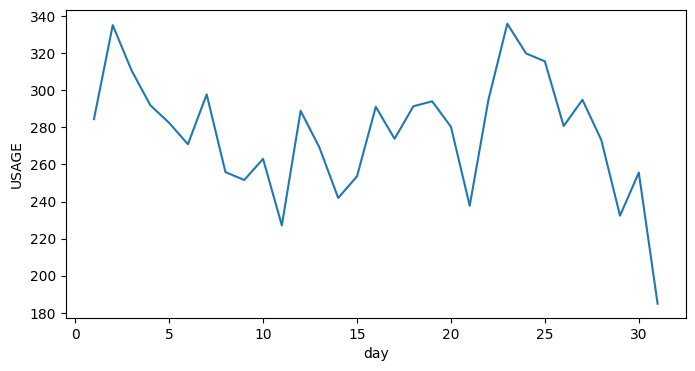

In [ ]:
# Day Trend
day_df = df.groupby(['day']).agg({'USAGE':'sum'})
day_df['day'] = day_df.index
plt.figure(figsize=(8,4))
sns.lineplot(data = day_df, x= day_df['day'], y=day_df['USAGE'])

<Axes: xlabel='month', ylabel='USAGE'>

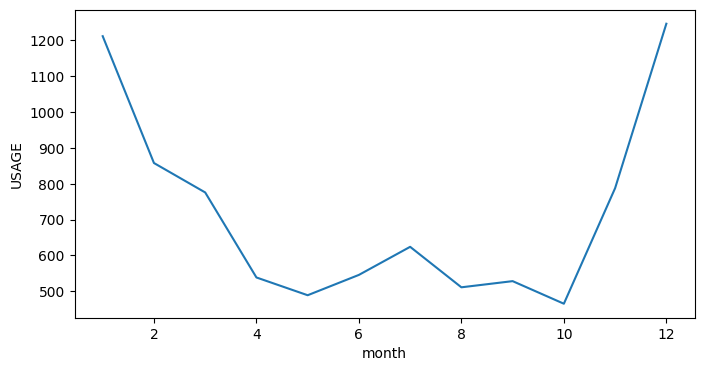

In [ ]:
# Month Trend
month_df = df.groupby(['month']).agg({'USAGE':'sum'})
month_df['month'] = month_df.index
plt.figure(figsize=(8,4))
sns.lineplot(data = month_df, x= month_df['month'], y=month_df['USAGE'])

<Axes: xlabel='year', ylabel='USAGE'>

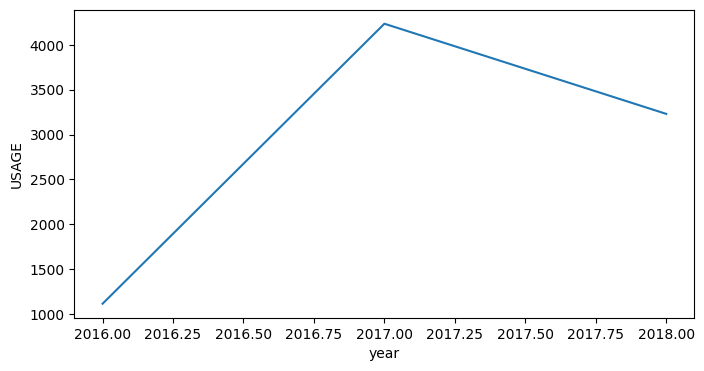

In [ ]:
# Yearly Trend
year_df = df.groupby(['year']).agg({'USAGE':'sum'})
year_df['year'] =year_df.index
plt.figure(figsize=(8,4))
sns.lineplot(data = year_df, x= year_df['year'], y=year_df['USAGE'])

(None, None)

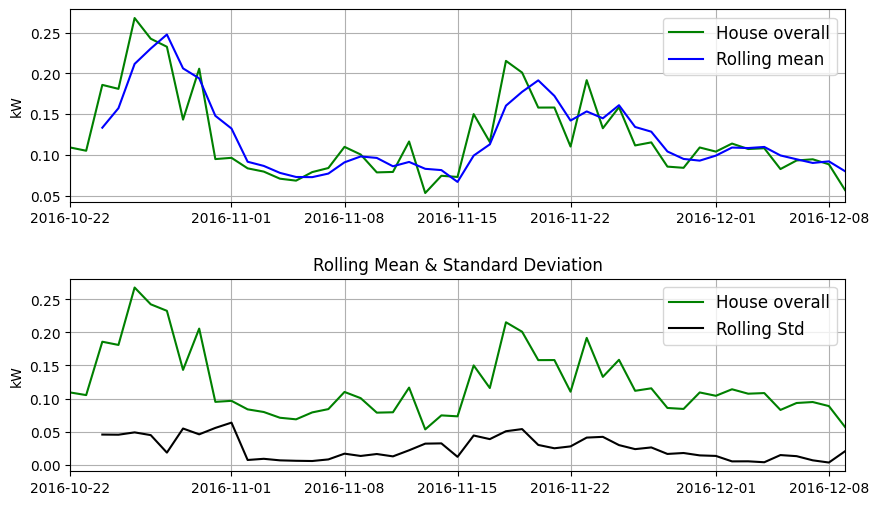

In [ ]:
# Data resampling by day
data_daily = df['USAGE'].resample('d').mean() # based on USAGE of energy
rollingMEAN = data_daily.rolling(window=3).mean()
rollingSTD = data_daily.rolling(window=3).std()

#Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
plt.subplots_adjust(hspace=0.4)
plt.title('Rolling Mean & Standard Deviation')
ax1.plot(data_daily, c='green',label='House overall')
ax1.plot(rollingMEAN, c='blue', label='Rolling mean')

ax2.plot(data_daily, c='green',label='House overall')
ax2.plot(rollingSTD, c='black',label = 'Rolling Std')

ax1.legend(fontsize=12), ax2.legend(fontsize=12)
ax1.set_ylabel('kW'), ax2.set_ylabel('kW')
ax1.margins(x=0), ax2.margins(x=0)
ax1.grid(), ax2.grid()

###Seasonality

<Figure size 640x480 with 0 Axes>

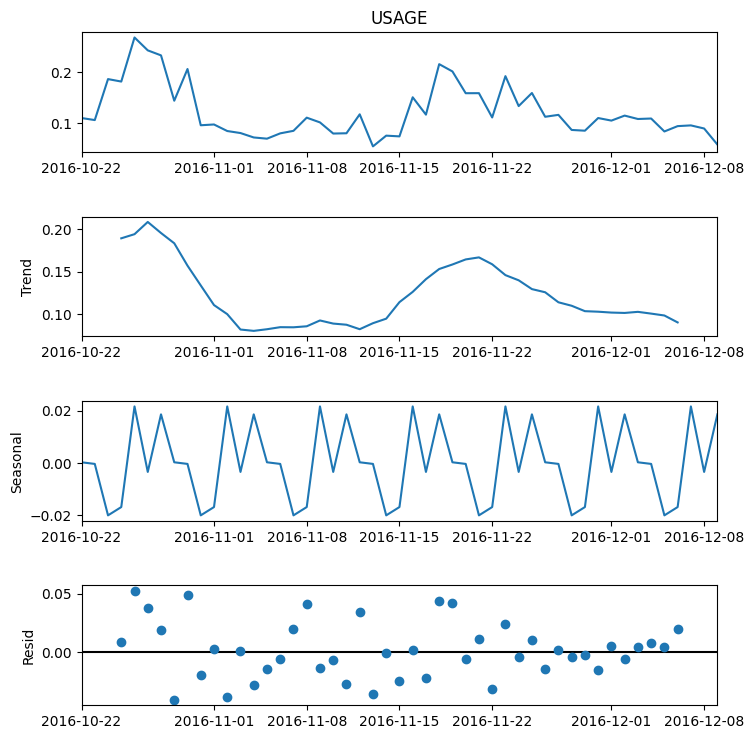

In [ ]:
result = seasonal_decompose(data_daily, model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 8)

###Auto ARIMA

In [ ]:
size = int(len(data_daily)*0.7)
train = data_daily[:size]
test = data_daily[size:]

arima_model = auto_arima(train,
                         start_p=0,
                         d=0,
                         start_q=0,
                         max_p=5,
                         max_d=5,
                         max_q=5,
                         start_P=0,
                         D=1,
                         start_Q=0,
                         max_P=5,
                         max_D=5,
                         max_Q=5,
                         m=12,
                         seasonal=True,
                         error_action='warn',
                         trace=True,
                         suppress_warnings=True,
                         stepwise=True,
                         random_state=20,
                         n_fits=5
                        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-40.079, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-56.440, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-41.517, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-54.748, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-54.443, Time=1.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-54.457, Time=0.80 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-52.461, Time=2.80 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-52.300, Time=0.17 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-60.668, Time=0.64 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-58.136, Time=0.17 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-58.833, Time=0.82 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=in

###ARIMA

In [ ]:
model = ARIMA(train, order=(1, 1, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  USAGE   No. Observations:                   34
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  56.538
Date:                Tue, 20 Jun 2023   AIC                           -109.076
Time:                        09:39:46   BIC                           -106.083
Sample:                    10-22-2016   HQIC                          -108.069
                         - 11-24-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4436      0.198     -2.240      0.025      -0.832      -0.056
sigma2         0.0019      0.001      3.716      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.55   Prob(JB):                         0.96
Heteroskedasticity (H):               0.69   Skew:                             0.10
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = ARIMA(train, order=(2, 0, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  USAGE   No. Observations:                   34
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  59.851
Date:                Tue, 20 Jun 2023   AIC                           -111.701
Time:                        09:40:13   BIC                           -105.596
Sample:                    10-22-2016   HQIC                          -109.619
                         - 11-24-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1306      0.034      3.789      0.000       0.063       0.198
ar.L1          0.4239      0.184      2.299      0.022       0.062       0.785
ar.L2          0.3173      0.188      1.685      0.092      -0.052       0.686
sigma2         0.0017      0.001      3.144      0.002       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.46   Prob(JB):                         0.37
Heteroskedasticity (H):               0.63   Skew:                             0.58
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###Using AutoGluon

In [ ]:
df2.drop(columns=['UNITS', 'START TIME','END TIME'], inplace=True)

In [ ]:
df2['COST'] = df2['COST'].str.replace('$',' ').astype(float)

<ipython-input-112-4b7297e3fcbc>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df2['COST'] = df2['COST'].str.replace('$',' ').astype(float)


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

data = TimeSeriesDataFrame.from_data_frame(
    df2,
    id_column='TYPE',
    timestamp_column='DATE'
)
data.head()

USAGE  COST  year  month  day  hour  minute
item_id        timestamp                                              
Electric usage 2016-10-22   0.01   0.0  2016     10   22     0       0
               2016-10-22   0.01   0.0  2016     10   22     0      15
               2016-10-22   0.01   0.0  2016     10   22     0      30
               2016-10-22   0.01   0.0  2016     10   22     0      45
               2016-10-22   0.01   0.0  2016     10   22     1       0

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=24,target="COST", eval_metric="MASE", ignore_time_index=True)

predictor.fit(data,presets="high_quality",time_limit=600)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: high_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MASE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'high_quality',
 'num_val_windows': 1,
 'prediction_length': 24,
 'random_seed': None,
 'target': 'COST',
 'time_limit': 600,
 'verbosity': 2}
Provided training data set with 70368 rows, 1 items (item = single time series). Average time series length is 70368.0. Data frequency is 'S'.
AutoGluon will save models to AutogluonModels/ag-20230620_110714/
AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'COST'
	past covariates:  ['USAGE', 'year', 'month', 'day', 'hour', 'minute

In [ ]:
predictions = predictor.predict(data)
predictions.head()

INFO:lightning_fabric.utilities.seed:Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: Naive


mean       0.1       0.2       0.3  \
item_id        timestamp                                                 
Electric usage 1900-01-01 19:32:48  0.01 -0.000096  0.003370  0.005869   
               1900-01-01 19:32:49  0.01 -0.004278  0.000623  0.004157   
               1900-01-01 19:32:50  0.01 -0.007487 -0.001484  0.002844   
               1900-01-01 19:32:51  0.01 -0.010192 -0.003261  0.001737   
               1900-01-01 19:32:52  0.01 -0.012576 -0.004826  0.000762   

                                         0.4   0.5       0.6       0.7  \
item_id        timestamp                                                 
Electric usage 1900-01-01 19:32:48  0.008004  0.01  0.011996  0.014131   
               1900-01-01 19:32:49  0.007177  0.01  0.012823  0.015843   
               1900-01-01 19:32:50  0.006543  0.01  0.013457  0.017156   
               1900-01-01 19:32:51  0.006008  0.01  0.013992  0.018263   
               1900-01-01 19:32:52  0.005537  0.01  0.014463  0.019238   

                                         0.8       0.9  
item_id        timestamp                                
Electric usage 1900-01-01 19:32:48  0.016630  0.020096  
               1900-01-01 19:32:49  0.019377  0.024278  
               1900-01-01 19:32:50  0.021484  0.027487  
               1900-01-01 19:32:51  0.023261  0.030192  
               1900-01-01 19:32:52  0.024826  0.032576

In [ ]:
predictor.leaderboard(data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SeasonalNaive,-0.712760,-0.712760,0.037864,0.107485,0.252821,2
1,Naive,-0.712760,-0.712760,0.028270,0.132836,0.245646,1
2,AutoETS,-0.712760,-0.712760,0.150512,0.551676,0.278370,4
3,RecursiveTabular,-0.766839,-0.766839,0.580639,0.603511,3.483354,5
4,Theta,-0.889475,-0.889475,0.549376,1.528579,0.298795,3
5,DeepAR,-1.382458,-1.403536,0.229278,0.374224,592.356938,6
